In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [16]:
def sample_circles(n_samples):
    return datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

def sample_moons(n_samples):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    return noisy_moons

def sample_blobs(n_samples):
    blobs = datasets.make_blobs(n_samples=n_samples)
    return blobs

def sample_aniso(n_samples):
    X, y = datasets.make_blobs(n_samples=n_samples)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)
    return aniso

def sample_varied(n_samples):
    varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5])
    return varied



In [3]:
settings = [noisy_circles, noisy_moons, blobs, aniso, varied]

In [4]:
colors = ["blue", "orange", "green"]

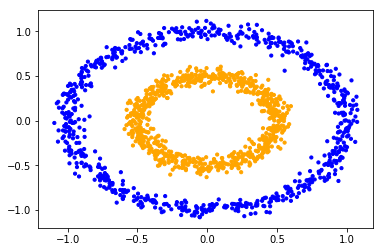

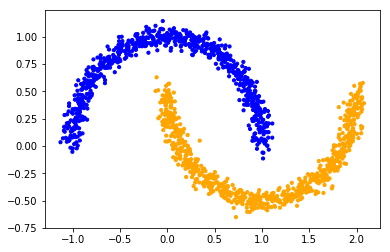

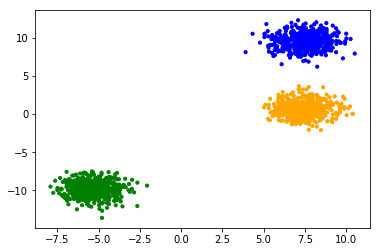

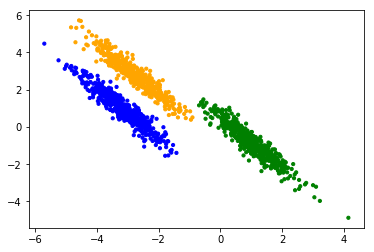

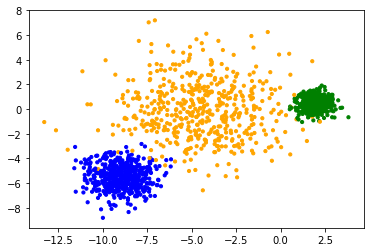

In [5]:

for setting in settings:
    X, y = setting
    plt.scatter(X[:, 0], X[:, 1], s=10, color=[colors[i] for i in y])
    plt.show()

In [3]:
import sys
sys.path.append("code/")
from entropy_estimators import micd
from mixed import Mixed_KSG

In [12]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 1000, max_samples = .32, depth = 40):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators = n_estimators, max_samples = max_samples, depth = depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy


np.warnings.filterwarnings('ignore')


In [10]:
from tqdm import tqdm_notebook
import sys
sys.path.insert(0, "./code")
import entropy_estimators as ee
import mixed

def mutual_information_circles():
    samples = [i*100 for i in range(1, 50)]
    uf = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(samples):
        X, y = sample_circles(n)
        kraskov.append(micd(X, y.reshape(-1, 1)))
        uf.append(get_mutual_information(X, y))
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1)))
    return samples, uf, kraskov, mixed_ksg

In [29]:
samples, uf, kraskov, mixed_ksg = mutual_information_circles()

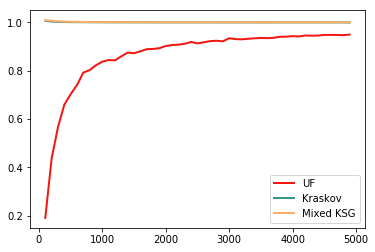

In [30]:
entr = -.5*np.log(.5) - .5*np.log(.5)

line_cef, = plt.plot(samples, np.array(uf)/entropy, label = "UF", linewidth = 2, color = "#F41711")
line_kraskov, = plt.plot(samples, kraskov, label = "Kraskov", linewidth = 2, color = "#35978f")
line_ksg, = plt.plot(samples, mixed_ksg/entropy, label = "Mixed KSG", linewidth = 2, color = "#fdae61")
plt.legend()

[0.19074122 0.4367172  0.56676634 0.65953905 0.70318369 0.74074159
 0.79246892 0.8028337  0.8230016  0.83774951 0.8444258  0.84329999
 0.85993648 0.87541443 0.87266037 0.88051364 0.88937352 0.89029933
 0.89356045 0.90251974 0.90663986 0.90812048 0.91191407 0.91929166
 0.91326245 0.91803148 0.92262103 0.92427221 0.92186569 0.93460541
 0.93097921 0.93022552 0.93238126 0.93443261 0.93579505 0.9351006
 0.93636771 0.94096745 0.94112455 0.94335606 0.94205917 0.94607841
 0.94508998 0.94575126 0.94831059 0.94849581 0.94811259 0.94755014
 0.9497097 ]


In [17]:
from tqdm import tqdm_notebook
import sys
sys.path.insert(0, "./code")
import entropy_estimators as ee
import mixed

def mutual_information_moons():
    samples = [i*100 for i in range(1, 50)]
    uf = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(samples):
        X, y = sample_moons(n)
        kraskov.append(micd(X, y.reshape(-1, 1)))
        uf.append(get_mutual_information(X, y))
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1)))
    return samples, uf, kraskov, mixed_ksg

In [18]:
entr = -.5*np.log(.5) - .5*np.log(.5)

samples, uf, kraskov, mixed_ksg = mutual_information_moons()

In [19]:
np.random.seed(0)
X, y = sample_moons(5000)
rf_entropy_estimate_bagging(X, y)

0.040597675712092954

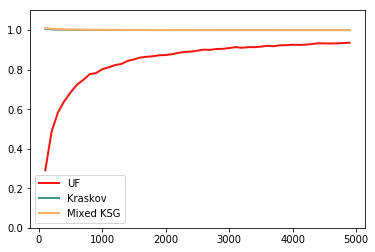

In [20]:
entr = -.5*np.log(.5) - .5*np.log(.5)

line_cef, = plt.plot(samples, np.array(uf)/entr, label = "UF", linewidth = 2, color = "#F41711")
line_kraskov, = plt.plot(samples, kraskov, label = "Kraskov", linewidth = 2, color = "#35978f")
line_ksg, = plt.plot(samples, mixed_ksg/entr, label = "Mixed KSG", linewidth = 2, color = "#fdae61")
plt.ylim(ymin = 0)
plt.ylim(ymax = 1.1)
plt.legend()

In [9]:
from tqdm import tqdm_notebook
import sys
sys.path.insert(0, "./code")
import entropy_estimators as ee
import mixed

def mutual_information_blobs():
    samples = [i*100 for i in range(1, 50)]
    uf = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(samples):
        X, y = sample_blobs(n)
        kraskov.append(ee.micd(X, y.reshape(-1, 1)))
        uf.append(get_mutual_information(X, y))
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1)))
    return samples, uf, kraskov, mixed_ksg

In [10]:
samples, uf_blobs, kraskov_blobs, mixed_ksg_blobs = mutual_information_blobs()

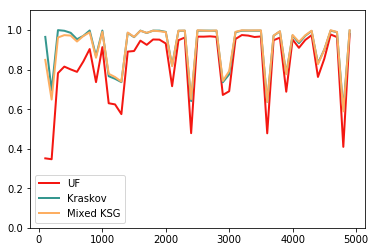

In [25]:
entr = -np.log(.3333)

line_cef, = plt.plot(samples, np.array(uf_blobs)/entr, label = "UF", linewidth = 2, color = "#F41711")
ksg_max = max(kraskov_blobs)

line_kraskov, = plt.plot(samples, kraskov_blobs/ksg_max, label = "Kraskov", linewidth = 2, color = "#35978f")
line_ksg, = plt.plot(samples, mixed_ksg_blobs/entr, label = "Mixed KSG", linewidth = 2, color = "#fdae61")
plt.ylim(ymin = 0)
plt.ylim(ymax = 1.1)
plt.legend()

In [12]:
def mutual_information_aniso():
    samples = [i*100 for i in range(1, 50)]
    uf = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(samples):
        X, y = sample_aniso(n)
        kraskov.append(ee.micd(X, y.reshape(-1, 1)))
        uf.append(get_mutual_information(X, y))
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1)))
    return samples, uf, kraskov, mixed_ksg

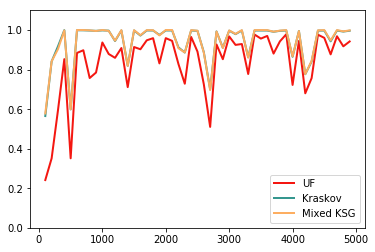

In [31]:
#samples, uf_aniso, kraskov_aniso, mixed_ksg_aniso = mutual_information_aniso()

line_cef, = plt.plot(samples, np.array(uf_aniso)/entr, label = "UF", linewidth = 2, color = "#F41711")
ksg_max = max(kraskov_aniso)
line_kraskov, = plt.plot(samples, kraskov_aniso/ksg_max, label = "Kraskov", linewidth = 2, color = "#35978f")
line_ksg, = plt.plot(samples, mixed_ksg_aniso/entr, label = "Mixed KSG", linewidth = 2, color = "#fdae61")
plt.ylim(ymin = 0)
plt.ylim(ymax = 1.1)
plt.legend()

In [14]:
def mutual_information_varied():
    samples = [i*100 for i in range(1, 50)]
    uf = []
    kraskov = []
    mixed_ksg = []
    for n in tqdm_notebook(samples):
        X, y = sample_varied(n)
        kraskov.append(ee.micd(X, y.reshape(-1, 1)))
        uf.append(get_mutual_information(X, y))
        mixed_ksg.append(mixed.Mixed_KSG(X, y.reshape(-1, 1)))
    return samples, uf, kraskov, mixed_ksg

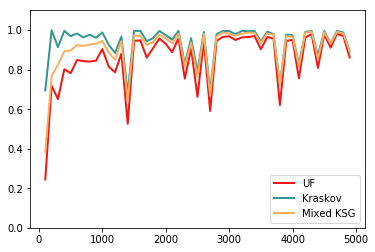

In [30]:
#samples, uf_varied, kraskov_varied, mixed_ksg_varied = mutual_information_varied()

line_cef, = plt.plot(samples, np.array(uf_varied)/entr, label = "UF", linewidth = 2, color = "#F41711")
ksg_max = max(kraskov_varied)
line_kraskov, = plt.plot(samples, kraskov_varied/ksg_max, label = "Kraskov", linewidth = 2, color = "#35978f")
line_ksg, = plt.plot(samples, mixed_ksg_varied/entr, label = "Mixed KSG", linewidth = 2, color = "#fdae61")
plt.ylim(ymin = 0)
plt.ylim(ymax = 1.1)
plt.legend()